# **Part 1 Basic**

Some preparations.

In [ ]:
%pip install --upgrade transformers
%pip install tf-keras
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'
%pip install datasets
%pip install evaluate

## **Fine-tune only the Classifier head**
The model I chose for the basic part 1 is also the distilbert.

We can download the model with a classifier from huggingface, and print the summary.

We can find that the model consists of the distilbert layer and a classifier consisting of two dense layers.

For now, all parameters are trainable.

In [ ]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import tensorflow as tf
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, id2label={0: 'negative', 1: 'neutral', 2: 'positive'})
model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreT

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


To determine how well my Pre-Trained model performs on financial data, we can freeze the distilbert layer.

Now, only the parameters of the classifier can be trained.

In [ ]:
distilbert_layer = model.get_layer('distilbert')
distilbert_layer.trainable = False
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 592899 (2.26 MB)
Non-trainable params: 66362880 (253.15 MB)
_________________________________________________________________


We access the dataset from the huggingface.

Then  we shuffle the dataset, and split it into trainset and testset.

Finally, we can convert the datasets to tf_datasets.

In [ ]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding
raw_datasets = load_dataset("financial_phrasebank", "sentences_allagree")
shuffled_dataset=raw_datasets["train"].shuffle(seed=99)
splited_datasets=shuffled_dataset.train_test_split(test_size=0.2)

def tokenize_function(example):
  return tokenizer(example["sentence"], truncation=True)
tokenized_datasets = splited_datasets.map(tokenize_function, batched=True)


data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    label_cols=["label"],
    collate_fn=data_collator,
    batch_size=12,
)

tf_test_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    label_cols=["label"],
    collate_fn=data_collator,
    batch_size=12,
)

Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/453 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Now, we can train the classifier.

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.fit(tf_train_dataset, epochs=3)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
151/151 [==============================] - 60s 33ms/step - loss: 0.5420 - accuracy: 0.7537
Epoch 2/3
151/151 [==============================] - 6s 37ms/step - loss: 0.3830 - accuracy: 0.8332
Epoch 3/3
151/151 [==============================] - 5s 33ms/step - loss: 0.3422 - accuracy: 0.8553


The, let's print the accuracy on the testset.

Even though we only trained the classifier, the result is already good.

In [ ]:
import numpy as np
import evaluate
preds = model.predict(tf_test_dataset)["logits"]

class_preds = np.argmax(preds, axis=1)
metric = evaluate.load("accuracy")
metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])

38/38 [==============================] - 6s 32ms/step


{'accuracy': 0.8322295805739515}

We can save the model for part 2.

In [ ]:
model.save_pretrained('saved_model_path')

## **Keeping the trained Classifier head of the first part: Fine-tune all the weights**

Now, let's freeze the parameters of the classifier and set the parameters of the distilbert layer trainable.

In [ ]:
for layer in model.layers:
  layer.trainable = False
model.get_layer("distilbert").trainable = True
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 592899 (2.26 MB)
_________________________________________________________________


If I use the previous opt and loss, the results are even wrose than only fine-tuning the classifier.

The screenshot of the results if I use the previous opt and loss: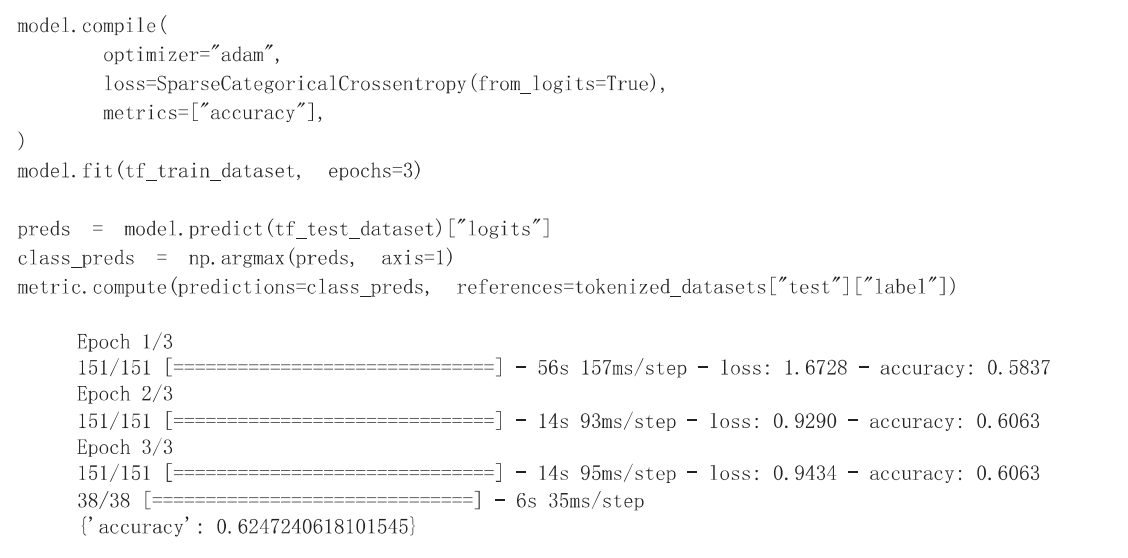

The reason is the learning rate is too high so that the parameters may "forget" their prior training.

Thus, we can usee the opt and loss that our huggingface course used.

Then, let's try again.

We can find that the accuracy is pretty high.

In [ ]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
batch_size = 12
num_epochs = 3

num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

model.fit(tf_train_dataset, epochs=3)

preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])

Epoch 1/3
151/151 [==============================] - 58s 173ms/step - loss: 0.1966 - accuracy: 0.9260
Epoch 2/3
151/151 [==============================] - 13s 88ms/step - loss: 0.0300 - accuracy: 0.9873
Epoch 3/3
38/38 [==============================] - 6s 33ms/step


{'accuracy': 0.9735099337748344}

## **Fine-tune all the weights (Pre-Trained + Classifier Head) simultaneously**

Let's redownload the model to make sure all parameters are untrained and trainable.

In [ ]:
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, id2label={0: 'negative', 1: 'neutral', 2: 'positive'})
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_39 (Dropout)        multiple                  0 (unused)
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 66955779 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's fine-tune all the parameters and test the performace on the testset.

The result is similar to the sub-part2.

In [ ]:
opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
model.fit(tf_train_dataset, epochs=3)

preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])

Epoch 1/3
151/151 [==============================] - 56s 159ms/step - loss: 0.3437 - accuracy: 0.8691
Epoch 2/3
151/151 [==============================] - 14s 92ms/step - loss: 0.0810 - accuracy: 0.9763
Epoch 3/3
38/38 [==============================] - 6s 45ms/step


{'accuracy': 0.9668874172185431}

# **Part 1 Extra**

## **Create my own Classification head**

First, let's download a model without a classifier.

We can see there is only one layer in the model.

In [ ]:
from transformers import TFAutoModel

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The classifier of the model in the basic part is nothing but two dense layers.

Let's try to replicate it first.

After that, we can try to create something different.

---

The shape of the output should be (None, 3), the label.

However, the headless model's output shape is (None, None, 768), the hidden_state.

We only intercept the first column of hidden_state and change the shape to (None, 768).

Then, we can just add two dense layers same to the model with an autohead to change the output to labels (None, 3).

---

It's worth noting that I can't seem to input the entire tf_dataset into the model like before, keras seems to be incompatible in this issue. So I put input_ids and attention_mask separately.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
transformer_model = TFAutoModel.from_pretrained(checkpoint)

class CustomModel(tf.keras.Model):
    def __init__(self, transformer, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transformer = transformer

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state

input_ids = tf.keras.Input(shape=(None,), dtype=tf.int64, name='input_ids')
attention_mask = tf.keras.Input(shape=(None,), dtype=tf.int64, name='attention_mask')

distilbert_model = CustomModel(transformer_model)
hidden_state=distilbert_model({'input_ids': input_ids, 'attention_mask': attention_mask})
pooled_output = hidden_state[:, 0]

logits=keras.Sequential([layers.Dense(768, activation="relu"),layers.Dense(3, activation="relu"),])(pooled_output)

keras_model = tf.keras.Model(inputs={'input_ids': input_ids, 'attention_mask': attention_mask}, outputs=logits)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


We can see that the parameters number of our model with our own classifier is the same as part 1 basic.

That's a good start.

We can also plot what the layers of the model look like.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 custom_model (CustomModel)  (None, None, 768)            6636288   ['attention_mask[0][0]',      
                                                          0          'input_ids[0][0]']           
                                                                                              

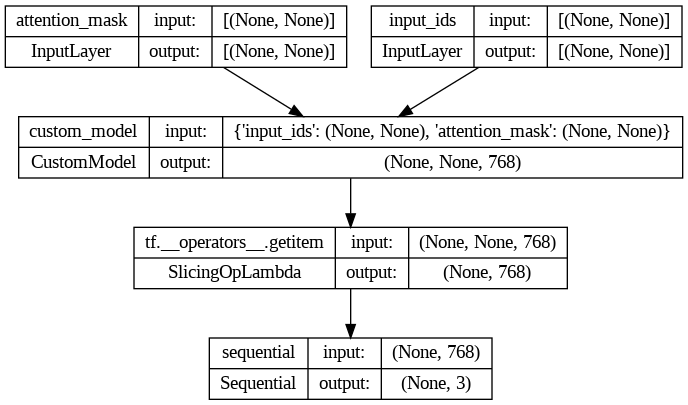

In [ ]:
keras_model.summary()
import tempfile
tempdir = tempfile.gettempdir()
keras.utils.plot_model(keras_model, os.path.join(tempdir,"autoencoder.png"), show_shapes=True)

Then, let test our model.

The results are good, too.

In [ ]:
opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
keras_model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

keras_model.fit(tf_train_dataset, epochs=3)
preds = keras_model.predict(tf_test_dataset)
class_preds = np.argmax(preds, axis=1)

metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])

Epoch 1/3


/tmp/__autograph_generated_file2yv922m4.py:63: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(tensors).keys, (), None, fscope) if ag__.ld(n) not in ag__.ld(ref_input_names)],), None, fscope),), dict(stacklevel=2), fscope)


151/151 [==============================] - 57s 160ms/step - loss: 0.3275 - accuracy: 0.8758
Epoch 2/3
151/151 [==============================] - 14s 90ms/step - loss: 0.0683 - accuracy: 0.9746
Epoch 3/3
38/38 [==============================] - 6s 34ms/step


{'accuracy': 0.9646799116997793}

The classifier we create is actually more like sequential rather than functional, which is not really interesting.

Let's try to bulid a more complicated classifier.

Specifically, I divided the classifier into two paths, one is simple and sequential dense layers, and the other is some more complex layers.

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Concatenate, Dropout, BatchNormalization

transformer_model = TFAutoModel.from_pretrained(checkpoint)
distilbert_model = CustomModel(transformer_model)
hidden_state=distilbert_model({'input_ids': input_ids, 'attention_mask': attention_mask})

GAP1D_output = GlobalAveragePooling1D()(hidden_state)
dropout = Dropout(0.5)(GAP1D_output)

batch_norm = BatchNormalization()(dropout)
dropout_final = Dropout(0.5)(batch_norm)
lenth3_output = layers.Dense(3, activation='relu')(dropout_final)

pooled_output = hidden_state[:, 0]
Sequential_output=keras.Sequential([layers.Dense(768, activation="relu"),layers.Dense(256, activation="relu"),layers.Dense(3, activation="relu"),])(pooled_output)
concatenated_inputs = Concatenate()([lenth3_output, Sequential_output])
logits = layers.Dense(3, activation='relu')(concatenated_inputs)

keras_model_2 = tf.keras.Model(inputs={'input_ids': input_ids, 'attention_mask': attention_mask}, outputs=logits)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


We can show how our new classifier looks like.

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 custom_model_1 (CustomMode  (None, None, 768)            6636288   ['attention_mask[0][0]',      
 l)                                                       0          'input_ids[0][0]']           
                                                                                            

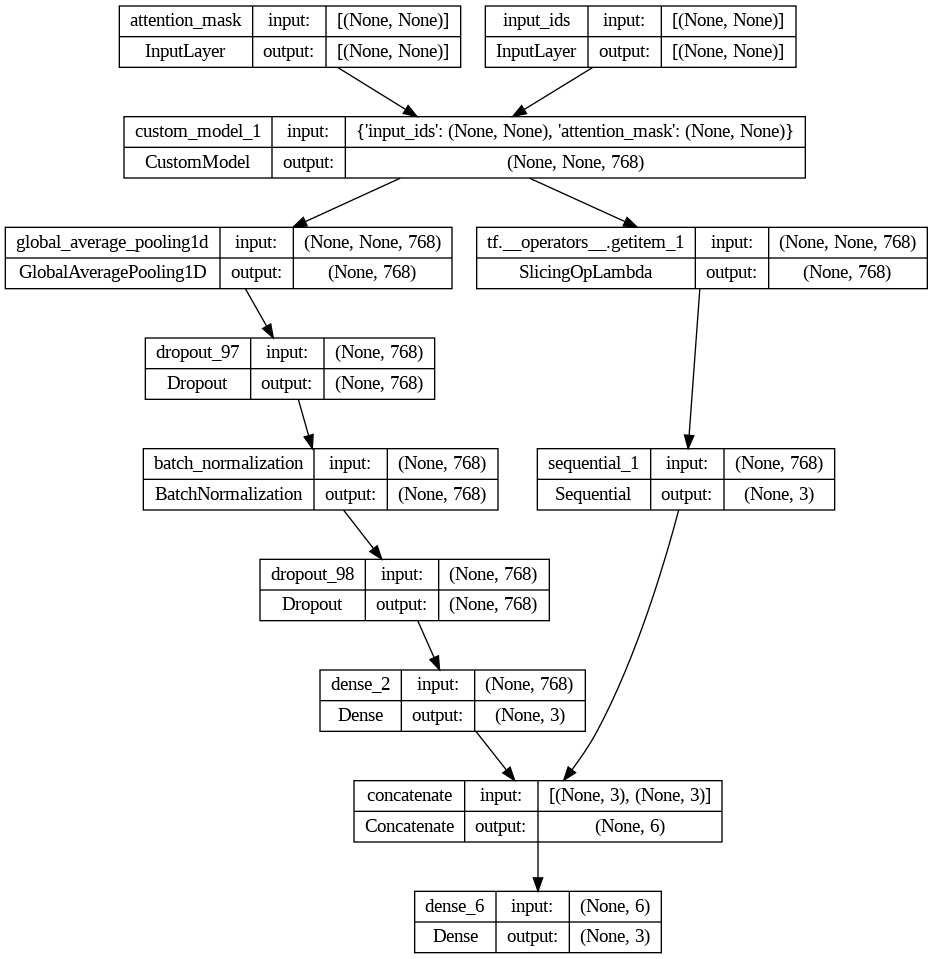

In [ ]:
keras_model_2.summary()
tempdir = tempfile.gettempdir()
keras.utils.plot_model(keras_model_2, os.path.join(tempdir,"autoencoder.png"), show_shapes=True)

Again, let's test our model.

The results were not significantly improved.

I would guess that an accuracy of around 96% might be the limit for a model of this size.

Thus, a simple classifier may be enough.

In [ ]:
opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
keras_model_2.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

keras_model_2.fit(tf_train_dataset, epochs=3)
preds = keras_model_2.predict(tf_test_dataset)
class_preds = np.argmax(preds, axis=1)

metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])

Epoch 1/3


/tmp/__autograph_generated_file2yv922m4.py:63: UserWarning: Input dict contained keys ['labels'] which did not match any model input. They will be ignored by the model.
  ag__.converted_call(ag__.ld(warnings).warn, (ag__.converted_call('Input dict contained keys {} which did not match any model input. They will be ignored by the model.'.format, ([ag__.ld(n) for n in ag__.converted_call(ag__.ld(tensors).keys, (), None, fscope) if ag__.ld(n) not in ag__.ld(ref_input_names)],), None, fscope),), dict(stacklevel=2), fscope)


151/151 [==============================] - 60s 165ms/step - loss: 1.0206 - accuracy: 0.6096
Epoch 2/3
151/151 [==============================] - 14s 91ms/step - loss: 0.2705 - accuracy: 0.9128
Epoch 3/3
38/38 [==============================] - 7s 44ms/step


{'accuracy': 0.9536423841059603}

# **Part 2 Basic**

Let's download our model with a well-trained classifier.

In [ ]:
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('saved_model_path')
preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
metric = evaluate.load("accuracy")
metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_118']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


38/38 [==============================] - 6s 33ms/step


{'accuracy': 0.8322295805739515}

Let’s freeze the parameters of all layers except FFNs.

In [ ]:
for layer in model.layers:
  layer.trainable = True

model.pre_classifier.trainable = False
model.classifier.trainable = False
model.distilbert.embeddings.trainable = False
for i in range(6):
  model.distilbert.transformer.layer[i].attention.trainable = False
  model.distilbert.transformer.layer[i].sa_layer_norm.trainable = False
  model.distilbert.transformer.layer[i].output_layer_norm.trainable = False
  model.distilbert.transformer.layer[i].dropout.trainable = False

model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_118 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 28334592 (108.09 MB)
Non-trainable params: 38621187 (147.33 MB)
_________________________________________________________________


We can define a LoraLayer class to replace 12 dense layers of 6 FFNs.

In [ ]:
import math
RANK=8
from tensorflow import keras
class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        lenth_of_B,
        rank=RANK,
        alpha=32,
        trainable=True,
        **kwargs,
    ):

        super().__init__(trainable=trainable,**kwargs)
        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self.original_layer = original_layer
        self.original_layer.trainable = False

        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            trainable=True,
            name=f"lora_A",
        )

        self.B = keras.layers.Dense(
            units=lenth_of_B,
            use_bias=False,
            trainable=True,
            name=f"lora_B",
        )


    def call(self, inputs):
        original_output = self.original_layer(inputs)
        lora_output = self.B(self.A(inputs)) * self._scale

        return original_output + lora_output

Since the shapes of lin1 and lin2 are different, we can replace them by using Loralayers with different shape.

Now, all the parameters are non-trainable, and the number of parameters is the same as the model without loralayers.

That's because the loralayers have not been instantiated yet. After training, the number of the parameters will increase.

In [ ]:
for i in range(6):
    FFN_layer = model.distilbert.transformer.layer[i].ffn
    FFN_layer.lin1 = LoraLayer(
        FFN_layer.lin1,
        lenth_of_B=3072,
        rank=RANK,
        trainable=True,
    )

    FFN_layer.lin2 = LoraLayer(
        FFN_layer.lin2,
        lenth_of_B=768,
        rank=RANK,
        trainable=True,
    )
model.summary()

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_118 (Dropout)       multiple                  0         
                                                                 
Total params: 66955779 (255.42 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 66955779 (255.42 MB)
_________________________________________________________________


Let's fine-tune our model with loralayers.

In [ ]:
opt = Adam(learning_rate=lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

model.fit(tf_train_dataset, epochs=3)

Epoch 1/3
151/151 [==============================] - 36s 71ms/step - loss: 0.3504 - accuracy: 0.8498
Epoch 2/3
151/151 [==============================] - 10s 69ms/step - loss: 0.2376 - accuracy: 0.9078
Epoch 3/3
151/151 [==============================] - 11s 70ms/step - loss: 0.2031 - accuracy: 0.9227


We can see that now the trainable parameters are the same as what we expect.

The accuracy is similar to fine-tuning all the parameters, which means our loralayers worked really well.

In [ ]:
model.summary()
preds = model.predict(tf_test_dataset)["logits"]
class_preds = np.argmax(preds, axis=1)
metric = evaluate.load("accuracy")
accuracy=metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])
print(accuracy)

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66731520  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_118 (Dropout)       multiple                  0         
                                                                 
Total params: 67324419 (256.82 MB)
Trainable params: 368640 (1.41 MB)
Non-trainable params: 66955779 (255.42 MB)
_________________________________________________________________
38/38 [==============================] - 

## **Required questions to answer**

Q: How does the performance of the model fine-tuned with LoRA compare to that of the pre-trained (not fine-tuned) model?

A: Significant improvement, from about 83% to about 93%.


---


Q: How does the performance of the model fine-tuned with LoRA compare to that of the model fine-tuned using the conventional approach?

A: The accuracy of LoRA is slightly lower than that of conventional approach.

This is reasonable since we only trained less than 1% of the parameters.


---

Q: How many LoRA parameters for each FFN block?

A: 2 x ( 768 x 8 + 8 x 3072 )= 61440


---


Q: How many LoRA parameters total ?

A: 61440 x 6 = 368640


---

Q: How many trainable parameters in your model?

A: 368640


---

Q: How many total parameters in your model?

A: 67324419


**Let's show code to compute the answer.**

In [ ]:
num_lora_eachffn =(model.distilbert.transformer.layer[0].ffn.lin1.A.count_params()+
                   model.distilbert.transformer.layer[0].ffn.lin1.B.count_params()+
                   model.distilbert.transformer.layer[0].ffn.lin2.A.count_params()+
                   model.distilbert.transformer.layer[0].ffn.lin2.B.count_params())
print("Number of each FFN layer's parameters: ",num_lora_eachffn)
added_total=6*num_lora_eachffn
print("Number of total LoRA parameters: ",added_total)
added_parms_calc=6*2*(768*8+8*3072)
print("Number of trainable parameters I expect: ",added_parms_calc)
assert(added_total == added_parms_calc)

Number of each FFN layer's parameters:  61440
Number of total LoRA parameters:  368640
Number of trainable parameters I expect:  368640


# **Part 2 Extra**

## **Change the rank number**

We can write a for loop to find the accuracy of the model with different lora ranks.

In [ ]:
Accuracies=[]
Ranks=[2, 4, 6, 8, 10, 12, 16, 20, 24, 32]
for r in Ranks:
  model = TFDistilBertForSequenceClassification.from_pretrained('saved_model_path')
  RANK=r
  print("rank=",RANK,":")

  model.pre_classifier.trainable = False
  model.classifier.trainable = False
  model.distilbert.embeddings.trainable = False
  for i in range(6):
    model.distilbert.transformer.layer[i].attention.trainable = False
    model.distilbert.transformer.layer[i].sa_layer_norm.trainable = False
    model.distilbert.transformer.layer[i].output_layer_norm.trainable = False
    model.distilbert.transformer.layer[i].dropout.trainable = False

  for i in range(6):
    FFN_layer = model.distilbert.transformer.layer[i].ffn
    FFN_layer.lin1 = LoraLayer(
        FFN_layer.lin1,
        lenth_of_B=3072,
        rank=RANK,
        trainable=True,
    )

    FFN_layer.lin2 = LoraLayer(
        FFN_layer.lin2,
        lenth_of_B=768,
        rank=RANK,
        trainable=True,
    )
  opt = Adam(learning_rate=lr_scheduler)
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
  model.fit(tf_train_dataset, epochs=3)
  preds = model.predict(tf_test_dataset)["logits"]
  class_preds = np.argmax(preds, axis=1)
  metric = evaluate.load("accuracy")
  accuracy=metric.compute(predictions=class_preds, references=tokenized_datasets["test"]["label"])
  Accuracies.append(accuracy['accuracy'])
  print(model.summary())
  print("rank=",model.distilbert.transformer.layer[0].ffn.lin1.rank)
  print(accuracy)


Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_498']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 2 :
Epoch 1/3
151/151 [==============================] - 50s 69ms/step - loss: 0.6152 - accuracy: 0.7432
Epoch 2/3
151/151 [==============================] - 10s 65ms/step - loss: 0.4483 - accuracy: 0.8084
Epoch 3/3
38/38 [==============================] - 8s 39ms/step
Model: "tf_distil_bert_for_sequence_classification_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66455040  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_498 (Dropout)       multiple                  0         
         

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_518']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 4 :
Epoch 1/3
151/151 [==============================] - 34s 70ms/step - loss: 0.4592 - accuracy: 0.8062
Epoch 2/3
151/151 [==============================] - 10s 67ms/step - loss: 0.3260 - accuracy: 0.8686
Epoch 3/3
38/38 [==============================] - 8s 41ms/step
Model: "tf_distil_bert_for_sequence_classification_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66547200  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_518 (Dropout)       multiple                  0         
         

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_538']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 6 :
Epoch 1/3
151/151 [==============================] - 37s 70ms/step - loss: 0.3983 - accuracy: 0.8388
Epoch 2/3
151/151 [==============================] - 11s 70ms/step - loss: 0.2669 - accuracy: 0.8962
Epoch 3/3
38/38 [==============================] - 7s 40ms/step
Model: "tf_distil_bert_for_sequence_classification_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66639360  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_538 (Dropout)       multiple                  0         
         

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_558']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 8 :
Epoch 1/3
151/151 [==============================] - 34s 70ms/step - loss: 0.3444 - accuracy: 0.8559
Epoch 2/3
151/151 [==============================] - 10s 69ms/step - loss: 0.2287 - accuracy: 0.9061
Epoch 3/3
38/38 [==============================] - 7s 39ms/step
Model: "tf_distil_bert_for_sequence_classification_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66731520  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_558 (Dropout)       multiple                  0         
         

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_578']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 10 :
Epoch 1/3
151/151 [==============================] - 34s 70ms/step - loss: 0.3113 - accuracy: 0.8592
Epoch 2/3
151/151 [==============================] - 11s 71ms/step - loss: 0.2032 - accuracy: 0.9227
Epoch 3/3
38/38 [==============================] - 8s 45ms/step
Model: "tf_distil_bert_for_sequence_classification_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66823680  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_578 (Dropout)       multiple                  0         
        

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_598']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 12 :
Epoch 1/3
151/151 [==============================] - 35s 70ms/step - loss: 0.3134 - accuracy: 0.8763
Epoch 2/3
151/151 [==============================] - 10s 68ms/step - loss: 0.1942 - accuracy: 0.9227
Epoch 3/3
38/38 [==============================] - 8s 40ms/step
Model: "tf_distil_bert_for_sequence_classification_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66915840  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_598 (Dropout)       multiple                  0         
        

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_618']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 16 :
Epoch 1/3
151/151 [==============================] - 34s 71ms/step - loss: 0.2754 - accuracy: 0.8846
Epoch 2/3
151/151 [==============================] - 11s 70ms/step - loss: 0.1680 - accuracy: 0.9348
Epoch 3/3
38/38 [==============================] - 7s 40ms/step
Model: "tf_distil_bert_for_sequence_classification_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  67100160  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_618 (Dropout)       multiple                  0         
        

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_638']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 20 :
Epoch 1/3
151/151 [==============================] - 34s 70ms/step - loss: 0.2764 - accuracy: 0.8851
Epoch 2/3
151/151 [==============================] - 11s 71ms/step - loss: 0.1723 - accuracy: 0.9371
Epoch 3/3
38/38 [==============================] - 8s 39ms/step
Model: "tf_distil_bert_for_sequence_classification_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  67284480  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_638 (Dropout)       multiple                  0         
        

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_658']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 24 :
Epoch 1/3
151/151 [==============================] - 56s 70ms/step - loss: 0.2636 - accuracy: 0.8956
Epoch 2/3
151/151 [==============================] - 11s 70ms/step - loss: 0.1751 - accuracy: 0.9299
Epoch 3/3
38/38 [==============================] - 8s 58ms/step
Model: "tf_distil_bert_for_sequence_classification_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  67468800  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_658 (Dropout)       multiple                  0         
        

Some layers from the model checkpoint at saved_model_path were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at saved_model_path and are newly initialized: ['dropout_678']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


rank= 32 :
Epoch 1/3
151/151 [==============================] - 34s 67ms/step - loss: 0.2704 - accuracy: 0.8868
Epoch 2/3
151/151 [==============================] - 10s 67ms/step - loss: 0.1820 - accuracy: 0.9266
Epoch 3/3
38/38 [==============================] - 8s 53ms/step
Model: "tf_distil_bert_for_sequence_classification_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  67837440  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
 dropout_678 (Dropout)       multiple                  0         
        

Now, we can drow a picture to see the relationship between the rank and the accuracy.

As shown in the figure, r=8 (or maybe 10?) is indeed a good choice. Before r=8, the accuracy increases significantly; after r=8, the accuracy only increases slowly or even decreases.

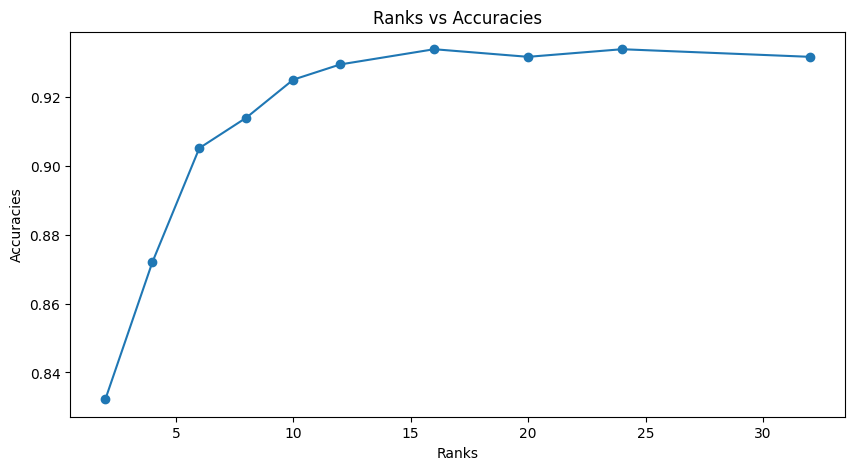

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(Ranks, Accuracies, marker='o')
plt.title('Ranks vs Accuracies')
plt.xlabel('Ranks')
plt.ylabel('Accuracies')
plt.show()